```{index} single: application; inventory management
```
```{index} single: solver; cbc
```
```{index} pandas dataframe
```
```{index} sample average approximation
```
```{index} stochastic optimization
```
```{index} simulations
```

# Stock optimization for seafood distribution center

## Preamble: Install Pyomo and a solver

This cell selects and verifies a global SOLVER for the notebook.

If run on Google Colab, the cell installs Pyomo and HiGHS, then sets SOLVER to 
use the Highs solver via the appsi module. If run elsewhere, it assumes Pyomo and CBC
have been previously installed and sets SOLVER to use the CBC solver via the Pyomo 
SolverFactory. It then verifies that SOLVER is available.

In [1]:
import sys

if 'google.colab' in sys.modules:
    !pip install pyomo >/dev/null 2>/dev/null
    !pip install highspy >/dev/null 2>/dev/null

    from pyomo.environ import SolverFactory
    SOLVER = SolverFactory('appsi_highs')
    
else:
    from pyomo.environ import SolverFactory
    SOLVER = SolverFactory('cbc')

assert SOLVER.available(), f"Solver {SOLVER} is not available."

In [2]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

## Problem description
Each day a seafood distribution center buys $x$ tons of tuna at the unit cost $c$ per ton. The next day a demand $z$ is observed from the retailers to whom the fish is sold at a unit price $p > c$. Any leftover tuna needs to be stored in a cold warehouse at a unit holding cost $h$. The seafood distribution center cannot sell more fish than it has in stock, thus at most $\min\{z, x \}$ tons will be sold which will leave $h(x-z)^+$ tons leftover, where $(\cdot)^+$ is the positive residual (that is $a^+:=\max\{0,a\}$). Accounting for these costs, the net profit is $p \min\{z, x \} - cx - h (x-z)^+.$

Given a reasonable estimate of the probability distribution $\mathbb P$ of the tuna demand $z$, to maximize the long-term net profit then we can formulate the following optimization problem:

$$
\begin{align*}
    \max \quad & \mathbb{E}  [ p \min\{z, x \} - cx - h (x-z)^+ ]\\
    \text{s.t.} \quad & x \geq 0.
\end{align*}
$$

Since we have $x \geq 0$ regardless of the demand $z$, the feasible set for the decision variable $x$ is not affected by unknown demand.

## Explicit analytical solution

Assume further that the demand for tuna in tons can be modeled as a continuous random variable $z$ with cumulative distribution function $F(\cdot)$. We consider the following three distributions:

1. A [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution#Cumulative_distribution_function) on the interval $[25, 175]$;

2. A [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution#Cumulative_distribution_function) on the interval $[50,+\infty)$ with $x_m=50$ and exponent $\alpha=2$. Recall that the inverse CDF for a Pareto distribution is given by* $F^{-1}(\varepsilon) = \frac{x_m}{(1-\varepsilon)^{1/\alpha}}$;

3. A [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution#Cumulative_distribution_function) on the interval $[0,+\infty)$ with shape parameter $k=2$ and scale parameter $\lambda=113$.

Note that all the three distributions above have the same expected value, that is $\mathbb E z = 100$ tons. 

The optimal solution of the seafood inventory problem using the closed-form formula that features the inverse CDFs/quantile functions $F^{-1}$ of the considered distribution, that is

$$
x^* = F^{-1} \left( \frac{p-c}{p+h}\right).
$$

In the example below, we report the numerical solution corresponding to the parameters $c = 10$, $p = 25$, and $h = 3$, which determine the quantile of interest, that is $q=\frac{p-c}{p+h} \approx 0.5357$. 

Mean of Uniform distribution = 100.00
Mean of Pareto distribution = 100.00
Mean of Weibull distribution = 100.00


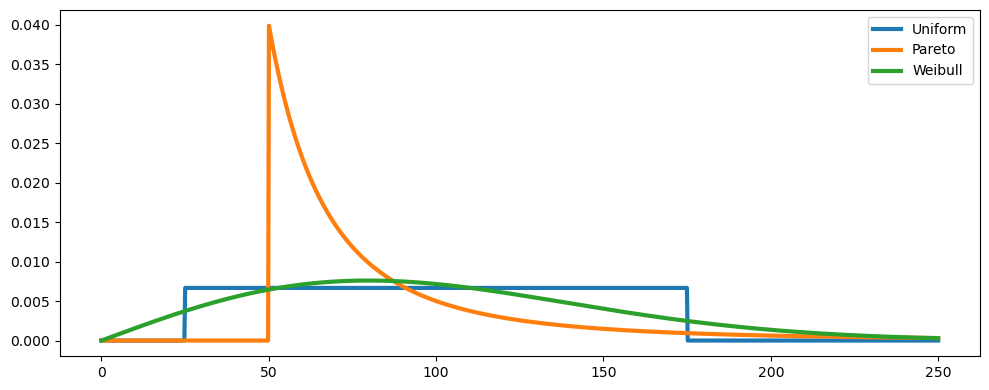

The quantile of interest given the parameters is equal to q = 0.5357.

The optimal solution for Uniform distribution is: 105.36 tons
The optimal solution for Pareto distribution is: 73.38 tons
The optimal solution for Weibull distribution is: 98.84 tons


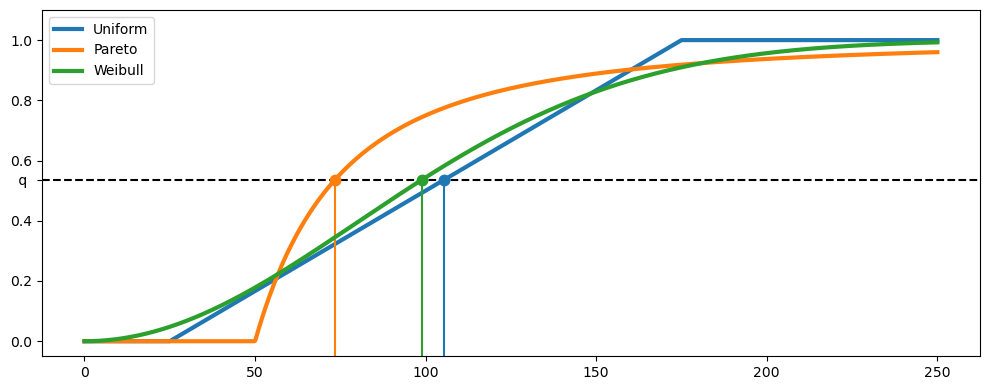

In [3]:
# Setting parameters
c = 10
p = 25
h = 3

distributions = {
    "Uniform": stats.uniform(loc=25, scale=150),
    "Pareto": stats.pareto(scale=50, b=2),
    "Weibull": stats.weibull_min(scale=112.838, c=2),
}

for name, distribution in distributions.items():
    print(f"Mean of {name} distribution = {distribution.mean():0.2f}")

# show PDFs
x = np.linspace(0, 250, 1000)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
lines = []
for name, distribution in distributions.items():
    ax.plot(x, distribution.pdf(x), lw=3, label=name)
ax.legend()
fig.tight_layout()
plt.show()

# quantile
q = (p - c) / (p + h)

# show CDFs and graphical solutions
extraticks = [q]
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.axhline(q, linestyle="--", color="k")
for name, distribution in distributions.items():
    x_opt = distribution.ppf(q)
    (line,) = ax.plot(x, distribution.cdf(x), lw=3, label=name)
    c = line.get_color()
    ax.plot([x_opt] * 2, [-0.05, q], color=c)
    ax.plot(x_opt, q, ".", color=c, ms=15)
plt.yticks(list(plt.yticks()[0]) + [q], list(plt.yticks()[1]) + [" q "])
plt.ylim(-0.05, 1.1)
ax.legend()
fig.tight_layout()

print(f"The quantile of interest given the parameters is equal to q = {q:.4f}.\n")

for name, distribution in distributions.items():
    x_opt = distribution.ppf(q)
    print(f"The optimal solution for {name} distribution is: {x_opt:0.2f} tons")

## Deterministic solution for average demand

We now find the optimal solution of the *deterministic linear problem model* obtained by assuming the demand is constant and equal to the average demand, i.e., $z = \bar{z} = \mathbb E z = 100$.

In [4]:
# problem data
c = 10
p = 25
h = 3

model = pyo.ConcreteModel()

# key parameter for possible parametric study
model.mean_demand = pyo.Param(initialize=100, mutable=True)

# first stage variables and expressions
model.x = pyo.Var(domain=pyo.NonNegativeReals)


@model.Expression()
def first_stage_profit(m):
    return -c * model.x


# second stage variables, constraints, and expressions
model.y = pyo.Var(domain=pyo.NonNegativeReals)
model.z = pyo.Var(domain=pyo.NonNegativeReals)


@model.Constraint()
def cant_sell_fish_i_dont_have(m):
    return m.y <= m.mean_demand


@model.Constraint()
def fish_do_not_disappear(m):
    return m.y + m.z == m.x


@model.Expression()
def second_stage_profit(m):
    return p * m.y - h * m.z


# objective
@model.Objective(sense=pyo.maximize)
def total_profit(m):
    return m.first_stage_profit + m.second_stage_profit


result = pyo.SolverFactory(SOLVER).solve(model)

assert result.solver.status == "ok"
assert result.solver.termination_condition == "optimal"

print(
    f"Optimal solution for determistic demand equal to the average demand = {model.x():.1f} tons"
)
print(f"Optimal deterministic profit = {model.total_profit():.0f}€")

Optimal solution for determistic demand equal to the average demand = 100.0 tons
Optimal deterministic profit = 1500€


## Profits resulting from using average demand

We now assess how well we perform by taking the average demand as input for each of the three demand distributions above.

For a fixed decision variable $x=100$, approximate the expected net profit of the seafood distribution center for each of the three distributions above using the Sample Average Approximation method with $N=2500$ points. More specifically, generate $N=2500$ samples from the considered distribution and solve the extensive form of the stochastic linear problem resulting from those $N=2500$ scenarios.

In [5]:
# SAA of the two-stage stochastic linear problem to calculate the expected profit when buying the average


def NaiveSeafoodStockSAA(N, sample, distributiontype):
    model = pyo.ConcreteModel()

    def indices_rule(model):
        return range(N)

    model.indices = pyo.Set(initialize=indices_rule)
    model.xi = pyo.Param(model.indices, initialize=dict(enumerate(sample)))

    # first stage variable: x (amount of fish bought)
    model.x = 100.0

    def first_stage_profit(model):
        return -c * model.x

    model.first_stage_profit = pyo.Expression(rule=first_stage_profit)

    # second stage variables: y (sold) and z (unsold)
    model.y = pyo.Var(model.indices, domain=pyo.NonNegativeReals)
    model.z = pyo.Var(model.indices, domain=pyo.NonNegativeReals)

    # second stage constraints
    model.cantsoldthingsfishdonthave = pyo.ConstraintList()
    model.fishdonotdisappear = pyo.ConstraintList()
    for i in model.indices:
        model.cantsoldthingsfishdonthave.add(expr=model.y[i] <= model.xi[i])
        model.fishdonotdisappear.add(expr=model.y[i] + model.z[i] == model.x)

    def second_stage_profit(model):
        return sum([p * model.y[i] - h * model.z[i] for i in model.indices]) / float(N)

    model.second_stage_profit = pyo.Expression(rule=second_stage_profit)

    def total_profit(model):
        return model.first_stage_profit + model.second_stage_profit

    model.total_expected_profit = pyo.Objective(rule=total_profit, sense=pyo.maximize)

    result = pyo.SolverFactory(SOLVER).solve(model)

    print(
        f"- {distributiontype}-distributed demand: {model.total_expected_profit():.2f}€"
    )

    return model.total_expected_profit()


np.random.seed(0)
N = 7500
print(
    f"Approximate expected optimal profit calculate with {N} samples when assuming the average demand with"
)

samples = np.random.uniform(low=25.0, high=175.0, size=N)
naiveprofit_uniform = NaiveSeafoodStockSAA(N, samples, "Uniform")

shape = 2
xm = 50
samples = (np.random.pareto(a=shape, size=N) + 1) * xm
naiveprofit_pareto = NaiveSeafoodStockSAA(N, samples, "Pareto")

shape = 2
scale = 113
samples = scale * np.random.weibull(a=shape, size=N)
naiveprofit_weibull = NaiveSeafoodStockSAA(N, samples, "Weibull")

Approximate expected optimal profit calculate with 7500 samples when assuming the average demand with
- Uniform-distributed demand: 966.36€
- Pareto-distributed demand: 787.71€
- Weibull-distributed demand: 910.55€


## Approximating the solution using Sample Average Approximation method

We now approximate the optimal solution of stock optimization problem for each of the three distributions above using the Sample Average Approximation method. More specifically, generate $N=5000$ samples from each of the three distributions and then solve the extensive form of the stochastic linear problem resulting from those $N=5000$ scenarios. For each of the three distribution, we compare the optimal expected profit with that obtained before and calculate the value of the stochastic solution (VSS).

In [6]:
# Two-stage stochastic linear problem using SAA


def SeafoodStockSAA(N, sample, distributiontype, printflag=True):
    model = pyo.ConcreteModel()

    def indices_rule(model):
        return range(N)

    model.indices = pyo.Set(initialize=indices_rule)
    model.xi = pyo.Param(model.indices, initialize=dict(enumerate(sample)))

    # first stage variable: x (amount of fish bought)
    model.x = pyo.Var(domain=pyo.NonNegativeReals)

    def first_stage_profit(model):
        return -c * model.x

    model.first_stage_profit = pyo.Expression(rule=first_stage_profit)

    # second stage variables: y (sold) and z (unsold)
    model.y = pyo.Var(model.indices, domain=pyo.NonNegativeReals)  # sold
    model.z = pyo.Var(
        model.indices, domain=pyo.NonNegativeReals
    )  # unsold to be returned

    # second stage constraints
    model.cantsoldfishidonthave = pyo.ConstraintList()
    model.fishdonotdisappear = pyo.ConstraintList()
    for i in model.indices:
        model.cantsoldfishidonthave.add(expr=model.y[i] <= model.xi[i])
        model.fishdonotdisappear.add(expr=model.y[i] + model.z[i] == model.x)

    def second_stage_profit(model):
        return sum([p * model.y[i] - h * model.z[i] for i in model.indices]) / float(N)

    model.second_stage_profit = pyo.Expression(rule=second_stage_profit)

    def total_profit(model):
        return model.first_stage_profit + model.second_stage_profit

    model.total_expected_profit = pyo.Objective(rule=total_profit, sense=pyo.maximize)

    result = pyo.SolverFactory(SOLVER).solve(model)

    if printflag:
        print(
            f"Approximate solution in the case of {distributiontype} distribution using N={N:.0f} samples"
        )
        print(f"Approximate optimal solution: x = {model.x.value:.2f} tons")
        print(
            f"Approximate expected optimal profit: {model.total_expected_profit():.2f}€"
        )

    return model.total_expected_profit(), model.x.value


np.random.seed(1)
N = 5000

samples = np.random.uniform(low=25.0, high=175.0, size=N)
smartprofit_uniform, x = SeafoodStockSAA(N, samples, "uniform")
print(
    f"Value of the stochastic solution: {smartprofit_uniform:.2f}-{naiveprofit_uniform:.2f} = {smartprofit_uniform-naiveprofit_uniform:.2f}€\n"
)

shape = 2
xm = 50
samples = (np.random.pareto(a=shape, size=N) + 1) * xm
smartprofit_pareto, x = SeafoodStockSAA(N, samples, "Pareto")
print(
    f"Value of the stochastic solution: {smartprofit_pareto:.2f}-{naiveprofit_pareto:.2f} = {smartprofit_pareto-naiveprofit_pareto:.2f}€\n"
)

shape = 2
scale = 113
samples = scale * np.random.weibull(a=shape, size=N)
smartprofit_weibull, x = SeafoodStockSAA(N, samples, "Weibull")
print(
    f"Value of the stochastic solution: {smartprofit_weibull:.2f}-{naiveprofit_weibull:.2f} = {smartprofit_weibull-naiveprofit_weibull:.2f}€\n"
)

Approximate solution in the case of uniform distribution using N=5000 samples
Approximate optimal solution: x = 105.82 tons
Approximate expected optimal profit: 979.98€
Value of the stochastic solution: 979.98-966.36 = 13.63€

Approximate solution in the case of Pareto distribution using N=5000 samples
Approximate optimal solution: x = 73.33 tons
Approximate expected optimal profit: 890.72€
Value of the stochastic solution: 890.72-787.71 = 103.00€

Approximate solution in the case of Weibull distribution using N=5000 samples
Approximate optimal solution: x = 100.06 tons
Approximate expected optimal profit: 919.08€
Value of the stochastic solution: 919.08-910.55 = 8.54€



## Convergence of the SAA method

The SAA method becomes more precise as the sample size $N$ increases. To illustrate this, we solve the same optimization problem as before but using a different number of samples, with the sample size $N$ increasing from $25$ to $2500$. As we can see, the approximate solutions converge to the theoretical ones as the sample size increases.

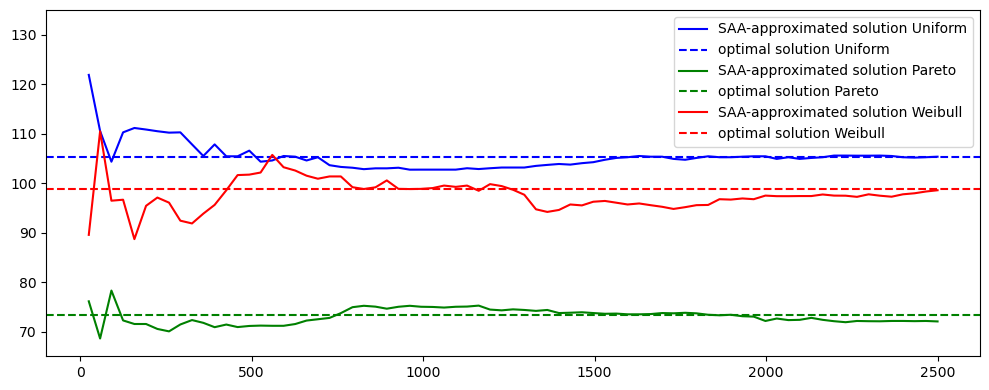

In [7]:
shape = 2
xm = 50
scale = 113
levels = 75

table = np.zeros((levels, 7))

for i, N in enumerate(np.linspace(25, 2500, levels, dtype=int)):
    np.random.seed(0)
    samples = np.random.uniform(low=25.0, high=175.0, size=N)
    profit_uniform, xu = SeafoodStockSAA(N, samples, "uniform", False)
    samples = (np.random.pareto(a=shape, size=N) + 1) * xm
    profit_pareto, xp = SeafoodStockSAA(N, samples, "Pareto", False)
    samples = scale * np.random.weibull(a=shape, size=N)
    profit_weibull, xw = SeafoodStockSAA(N, samples, "Weibull", False)
    table[i] = [N, xu, xp, xw, profit_uniform, profit_pareto, profit_weibull]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(table[:, 0], table[:, 1], "-b", label="SAA-approximated solution Uniform")
ax.axhline(y=105.36, color="b", linestyle="--", label="optimal solution Uniform")
ax.plot(table[:, 0], table[:, 2], "-g", label="SAA-approximated solution Pareto")
ax.axhline(y=73.38, color="g", linestyle="--", label="optimal solution Pareto")
ax.plot(table[:, 0], table[:, 3], "-r", label="SAA-approximated solution Weibull")
ax.axhline(y=98.84, color="r", linestyle="--", label="optimal solution Weibull")
ax.legend(loc="upper right")
plt.ylim(65, 135)
fig.tight_layout()